<a href="https://colab.research.google.com/github/JohnathonLG/cse455-final/blob/gh-pages/cse455_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the data in this VM and set up the device used for training

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from google.colab import drive
import shutil

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/stocknet/'
if not os.path.exists(checkpoints):
  os.makedirs(checkpoints)
if not os.path.exists('stocknet'):
  os.chdir('/content/')
  shutil.copy('/content/drive/MyDrive/cryptocharts.tar.gz', './cryptocharts.tar.gz')
  !tar -xf cryptocharts.tar.gz

Mounted at /content/drive


Load the data into torch

In [2]:
DATA_DIR = '/content/data/'
def get_data():
  # data is only a little augmented since we know we will always be looking at the same type of graph that is the same size
  transform_train = transforms.Compose([transforms.RandomCrop((253, 357), padding = 3, padding_mode='edge'),
    transforms.ToTensor()
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageFolder(root= DATA_DIR + 'train/', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder(root= DATA_DIR + 'test/', transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

  return {'train': trainloader, 'test': testloader}

data = get_data()

Show some examples of images we are using in a grid

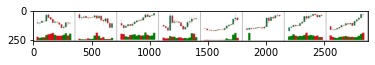

In [3]:
def show_image(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
show_image(torchvision.utils.make_grid(images))

The convolutional neural net made to process our graphs, adapted from Joseph Redmon's DarkNet architecture with a couple extra layers and stride of 2 to accomodate our larger pictures.

In [4]:
class StockNet(nn.Module):
    def __init__(self):
        super(StockNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)

        self.conv7 = nn.Conv2d(512, 1024, 3, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(1024)

        #self.conv8 = nn.Conv2d(1024, 2048, 3, padding=1, bias=False)
        #self.bn8 = nn.BatchNorm2d(2048)

        self.fc1 = nn.Linear(1024, 7)

    def forward(self, x):
        # Input 253x357x3

        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 127x179x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 64x90x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 32x45x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 16x23x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 8x12x256
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), kernel_size=2, stride=2) # 4x6x512
        x = F.max_pool2d(F.relu(self.bn7(self.conv7(x))), kernel_size=2, stride=2) # 2x3x1024
        #x = F.max_pool2d(F.relu(self.bn8(self.conv8(x))), kernel_size=2, stride=2) # 1x2x2048

        # Global average pooling across each channel
        x = F.adaptive_avg_pool2d(x, 1)                                            # 1x1x1024
        x = torch.flatten(x, 1)                                                    # vector 1024
        
        
        x = self.fc1(x)
        return x

Training and validation functions

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  dir_correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          #print(labels)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # also check to see if we got the direction of change right (bullish or bearish)
          for pred, lab in zip(predicted, labels):
              dir_correct += ((pred < 3 and lab < 3) or 
              (3 <= pred < 6 and 3 <= lab < 6)
              or (pred == lab == 6))
  return correct/total, dir_correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

Run this bit to train the net and show results

Learning rate: 0.100000
Learning rate: 0.010000
Learning rate: 0.001000
Learning rate: 0.000100
Learning rate: 0.000010
Training raw accuracy: 0.999246 Directional accuracy: 0.999401
Testing raw accuracy: 0.449086 Directional accuracy: 0.608816


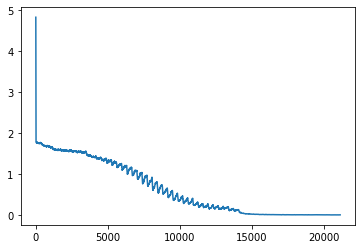

In [48]:
net = StockNet()
state = torch.load(checkpoints + 'darknet_7layers_60epochs.pkl')
losses = train(net, data['train'], epochs=60, schedule={0:.1, 10:.01, 30:.001, 40:.0001, 50:.00001}, checkpoint_path=checkpoints, state=state)
plt.plot(smooth(losses, 50))
mag_accuracy, dir_accuracy = accuracy(net, data['train'])
print("Training raw accuracy: %f Directional accuracy: %f" % (mag_accuracy, dir_accuracy))
mag_accuracy, dir_accuracy = accuracy(net, data['test'])
print("Testing raw accuracy: %f Directional accuracy: %f" % (mag_accuracy, dir_accuracy))

This will show some predictions the system makes on graphs it hasn't seen yet

In [46]:
def get_examples():
  transform = transforms.Compose([transforms.ToTensor(),])
  ex1 = torchvision.datasets.ImageFolder(root= checkpoints + '+5/', transform=transform)
  loader1 = torch.utils.data.DataLoader(ex1, batch_size=1, shuffle=False, num_workers=2)
  ex2 = torchvision.datasets.ImageFolder(root= checkpoints + 'n/', transform=transform)
  loader2 = torch.utils.data.DataLoader(ex2, batch_size=1, shuffle=False, num_workers=2)
  ex3 = torchvision.datasets.ImageFolder(root= checkpoints + 'unknown/', transform=transform)
  loader3 = torch.utils.data.DataLoader(ex3, batch_size=1, shuffle=False, num_workers=2)
  ex4 = torchvision.datasets.ImageFolder(root= checkpoints + '-10/', transform=transform)
  loader4 = torch.utils.data.DataLoader(ex4, batch_size=1, shuffle=False, num_workers=2)
  ex5 = torchvision.datasets.ImageFolder(root= checkpoints + '+1/', transform=transform)
  loader5 = torch.utils.data.DataLoader(ex5, batch_size=1, shuffle=False, num_workers=2)
  ex6 = torchvision.datasets.ImageFolder(root= checkpoints + '-1/', transform=transform)
  loader6 = torch.utils.data.DataLoader(ex6, batch_size=1, shuffle=False, num_workers=2)
  ex7 = torchvision.datasets.ImageFolder(root= checkpoints + '+10/', transform=transform)
  loader7 = torch.utils.data.DataLoader(ex7, batch_size=1, shuffle=False, num_workers=2)
  ex8 = torchvision.datasets.ImageFolder(root= checkpoints + '-5/', transform=transform)
  loader8 = torch.utils.data.DataLoader(ex8, batch_size=1, shuffle=False, num_workers=2)
  return {'+5': loader1, 'n': loader2, 'unknown': loader3, '-10': loader4, '+1': loader5, '-1': loader6, '+10': loader7, '-5': loader8}
examples = get_examples()

In [47]:
def check_examples(net):
  labels = ["+1", "+10", "+5", "-1", "-10", "-5", "n"]
  net.to(device)
  net.eval()
  for example in examples:
    for batch in examples[example]:
      image,label = batch[0].to(device), batch[1].to(device)
      outputs = net(image)
      _,predicted = torch.max(outputs.data, 1)
      print(example)
      print("Prediction:" + labels[predicted])

net = StockNet()
state = torch.load(checkpoints + 'darknet_7layers_60epochs.pkl')
losses = train(net, data['train'], epochs=60, schedule={0:.1, 10:.01, 30:.001, 40:.0001, 50:.00001}, checkpoint_path=checkpoints, state=state)
check_examples(net)



Learning rate: 0.100000
Learning rate: 0.010000
Learning rate: 0.001000
Learning rate: 0.000100
Learning rate: 0.000010
+5
Prediction:+5
n
Prediction:-5
unknown
Prediction:+1
-10
Prediction:-1
+1
Prediction:+5
-1
Prediction:-5
+10
Prediction:+10
-5
Prediction:-1
